## Utils

In [19]:
from abc import ABC, abstractmethod
import matplotlib.pyplot as plt
from IPython.display import clear_output
import torch
from torch import nn
from collections import deque

class Agent(ABC):
    def __init__(self, max_bufffer_size: int=5000):
        self.o = deque([], max_bufffer_size)
        self.a = deque([], max_bufffer_size)
        self.r = deque([], max_bufffer_size)
        self.t = deque([], max_bufffer_size)
        self.steps = 0
    @abstractmethod
    def act(self, observtion):
        pass
    def record_step(self, o, a, r, t):
        """Record an sample from environment interaction

        Args:
            o (): Observation
            a (): Action taken for that observation
            r (float): Reward return from that observation, action
            t (bool): Did the episode terminate with this sample
        """
        self.o.append(o)
        self.a.append(a)
        self.r.append(r)
        self.t.append(t)
        self.steps+=1


def run_one_episode(env, agent: Agent, render=False):
    o, _ = env.reset()
    terminated=False
    truncated=False
    steps = 0
    while not terminated and not truncated:
        if render:
            clear_output(True)
            plt.axis('off')
            plt.imshow(env.render())
            plt.pause(0.01)
        action = agent.act(o)
        next_o, reward, terminated, truncated, _ = env.step(action)
        agent.record_step(o, action, reward, terminated)
        o = next_o
        steps+=1
    return steps
    

        
def make_network(layers: list[int]):
    layers = [(i,j) for i,j in zip(layers[:-1], layers[1:])]
    layers = [nn.Linear(i, j) for i,j in layers]
    l = []
    for layer in layers[:-1]:
        l.append(layer)
        l.append(nn.ReLU())
    l.append(layers[-1])
    return nn.Sequential(*l)


## RandomAgent

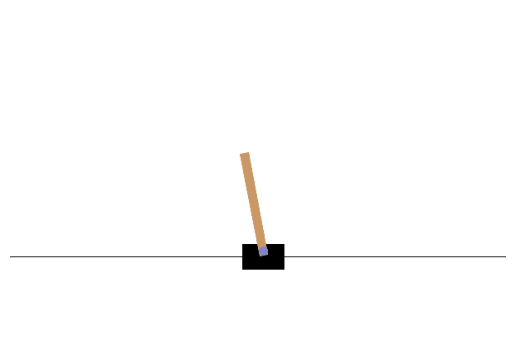

Accumulated 80.0 rewards, across 5 games
Mean returns for Random Agent, 16.0


In [15]:
import numpy as np
import gymnasium as gym
class RandomAgent(Agent):
    def act(self, observtion):
        return np.random.randint(2)

ra = RandomAgent()
env = gym.make("CartPole-v1", render_mode="rgb_array")
for _ in range(5):
    run_one_episode(env, ra, True)
env.close()
print(f"Accumulated {sum(ra.r)} rewards, across {sum(ra.t)} games")
print(f"Mean returns for Random Agent, {sum(ra.r)/sum(ra.t)}")

## DQN

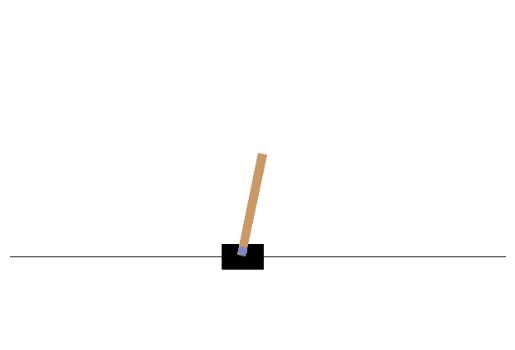

Accumulated 70.0 rewards, across 5 games
Mean returns for untrained_DQNndom Agent, 14.0


In [16]:
# Basic DQN
import torch
from torch import nn

class DQN(Agent):
    def __init__(self, network=None):
        super().__init__()
        self.network = make_network([4, 100, 100, 2]) if network is None else network
    def act(self, observtion):
        with torch.no_grad():
            o = torch.from_numpy(observtion)
            vals = self.network(o)
            return vals.argmax().item()

untrained_DQN = DQN()

env = gym.make("CartPole-v1", render_mode="rgb_array")
for _ in range(5):
    run_one_episode(env, untrained_DQN, True)
env.close()
print(f"Accumulated {sum(untrained_DQN.r)} rewards, across {sum(untrained_DQN.t)} games")
print(f"Mean returns for untrained_DQNndom Agent, {sum(untrained_DQN.r)/sum(untrained_DQN.t)}")


In [ ]:
# Training the DQN
from torch.utils.data import Dataset, DataLoader, Subset, RandomSampler
from tqdm import trange

import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import mlflow

class DQN_Dataset(Dataset): # requires __getitem__ and __len__
    def __init__(self, agent: Agent):
        """Create training dataset from an agents replay buffer

        Args:
            agent (Agent): Agent with environment interactions
        """
        super().__init__()

        o, a, r, t = agent.o, agent.a, agent.r, agent.t
        self.o = torch.tensor(np.stack(o)) 
        self.a = torch.tensor(a) 
        self.r = torch.tensor(r) 
        self.t = torch.tensor(t) 
        self.next_o = self.o.roll(-1)
    def __getitem__(self, index):
        return (
            self.o[index], # Observation
            self.a[index], # Action
            self.r[index], # Reward
            self.t[index], # Terminated
            self.next_o[index], # Next observation
        )
    def __len__(self):
        return len(self.o)

def eval_batch(network, batch, gamma):
    o, a, r, t, next_o = batch
    network_predictions = network(o)
    value_predictions = torch.stack([
        prediction[action]
        for prediction, action in zip(network_predictions, a)
        ])
    future_values = network(next_o).max(-1).values.detach()
    future_values[t] = 0
    loss = nn.functional.mse_loss(value_predictions, r+gamma*future_values)
    return torch.mean(loss)

def run_epoch(network:nn.Module, ds: Dataset, optim: torch.optim.Optimizer=None, gamma=0.9):
    dl = DataLoader(ds, 32, True)
    losses = []
    for batch in dl:
        loss = eval_batch(network, batch, gamma)
        if optim is not None:
            optim.zero_grad()
            loss.backward()
            optim.step()
        losses.append(loss.detach().item())
    return losses

def train(env, agent: DQN, iters: int=100, episodes_per_iter=10, train_val_split: float=0.8, lr:float=0.001):
    optim = torch.optim.AdamW(agent.network.parameters(), lr)
    for iter in trange(iters):
        steps = 0
        for episode in range(episodes_per_iter):
            steps += run_one_episode(env, agent)
        mean_return = sum(list(agent.r)[-steps:])/episodes_per_iter
        mlflow.log_metric("mean return", mean_return, step=agent.steps)
        ds = DQN_Dataset(agent)
        tds, vds = Subset(ds, range(int(len(ds)*train_val_split))), Subset(ds, range(int(len(ds)*train_val_split), len(ds)))
        mlflow.log_metric("dataset size", len(ds), step=agent.steps)
        training_losses = run_epoch(agent.network, tds, optim)
        val_losses = run_epoch(agent.network, vds)
        mlflow.log_metric("training loss", np.mean(training_losses), step=agent.steps)
        mlflow.log_metric("val loss", np.mean(val_losses), step=agent.steps)


dqn_agent = DQN()
env = gym.make("CartPole-v1")
with mlflow.start_run():
    params = {
        "iters": 1000,
        "episodes per itteration": 10,
        "learning rate": 0.001
    }
    mlflow.log_params(params)
    train(env, dqn_agent, params["iters"], params["episodes per itteration"], lr=params["learning rate"])
env.close()

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [09:10<00:00,  1.82it/s]


In [36]:
torch.save(dqn_agent.network.state_dict(), "dqn_net.pth")

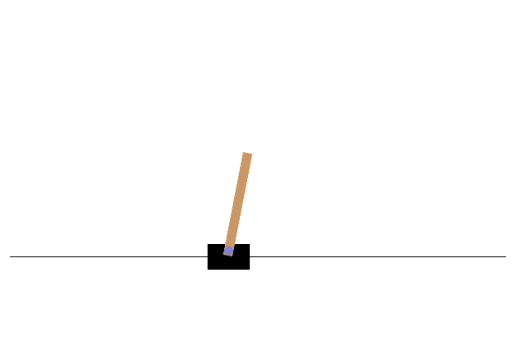

In [39]:
env = gym.make("CartPole-v1", render_mode="rgb_array")
agent = DQN()
agent.network.load_state_dict(torch.load("dqn_net.pth", weights_only=True))
run_one_episode(env, agent, True)
env.close()